In [1]:
%matplotlib inline
import math
import os 
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
import statsmodels.api as sm
from pandas import ExcelWriter
import pickle
import scipy as sp
from itertools import repeat

In [2]:
def load_object(filename):
    with open(filename, 'rb') as fid:
        file = pickle.load(fid)
    return file

In [3]:
#load the codes
Qian2016codes = load_object('models/revision/Qian2016codes_2.pkl')
Qian2018codes = load_object('models/revision/Qian2018codes_2.pkl')
QianU2019codes = load_object('models/revision/QianU2019codes_2.pkl')
QianR2019codes = load_object('models/revision/QianR2019codes_2.pkl')
Sourcecodes = load_object('models/revision/Sourcecodes_2.pkl')
Sourcetrainingcodes = load_object('models/revision//Sourcesamples_trainingcodes_2.pkl')
Sourcetestingcodes = load_object('models/revision//Sourcesamples_testingcodes_2.pkl')

#Load the DFs
Qian2016DF, Qian2016prob, Qian2016keys = load_object('models/revision/Qian2016DF_2.pkl')
Qian2018DF, Qian2018prob, Qian2018keys = load_object('models/revision/Qian2018DF_2.pkl')
QianU2019DF, QianU2019prob, QianU2019keys = load_object('models/revision/QianU2019DF_2.pkl')
QianR2019DF, QianR2019prob, QianR2019keys = load_object('models/revision/QianR2019DF_2.pkl')
SourceDF, Sourceprob, Sourcekeys = load_object('models/revision/SourceDF_2.pkl')
SourcetrainingDF, Sourcetrainingprob, Sourcekeys = load_object('models/revision/SourcetrainingDF_2.pkl')
SourcetestingDF, Sourcetestingprob, Sourcekeys = load_object('models/revision/SourcetestingDF_2.pkl')

clustersdata = [Qian2016DF, Qian2018DF, QianU2019DF, QianR2019DF, SourceDF]
probdata = [Qian2016prob, Qian2018prob, QianU2019prob, QianR2019prob, Sourceprob]
airkeys = [Qian2016keys, Qian2018keys, QianU2019keys, QianR2019keys, Sourcekeys]

In [4]:
# load urban fug dust 
Urbanfugdustcodes = load_object('models/revision/Urbfugdustcodes_2.pkl')

UrbanfugdustDF, Urbanfugdustprob, Urbanfugdustkeys = load_object('models/revision/UrbanfugdustDF_2.pkl')

In [5]:
def index(data, label):
    mini = data.reset_index()[data.reset_index()['labels'] == label].index.min()
    maxi = data.reset_index()[data.reset_index()['labels'] == label].index.max()
    return mini,maxi

## Threshold

In [6]:
tvdistance = []
for j in Sourcekeys:
    tvmid = []
    for i in Sourcekeys:
        tvmid.append(0.5*sp.spatial.distance.cdist(Sourcetestingprob[index(SourcetestingDF, j)[0]: index(SourcetestingDF, j)[1]],
                                                  Sourcetrainingprob[index(SourcetrainingDF, i)[0]: index(SourcetrainingDF, i)[1]], 'cityblock'))
    tvdistance.append(tvmid)

In [7]:
avglist = []
for l in tvdistance:
    avg = np.zeros([len(l[0]), 7])
    for i,j in enumerate(l):
        avg[:,i] = np.average(j, axis = 1)
    avglist.append(avg)

In [8]:
#input the distance metric of a sample point with a source
def threshold(datapoint, sourcekeys, value):
    index = np.where(datapoint < value)[0]
    if len(index) > 0:
        return [sourcekeys[i] for i in index.tolist()]
    else:
        return ['No Sources']

In [9]:
# add 'no sources' to Sourcekeys
Sourcekeys.append('No Sources')


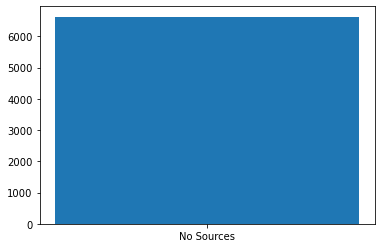

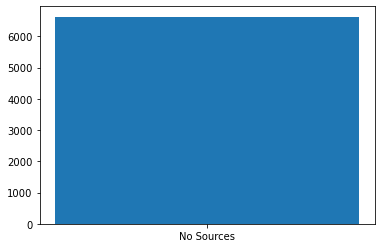

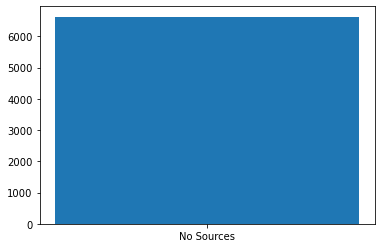

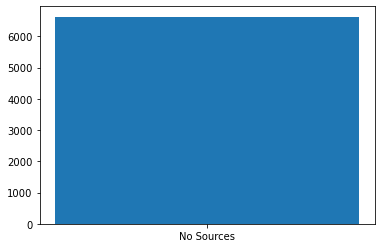

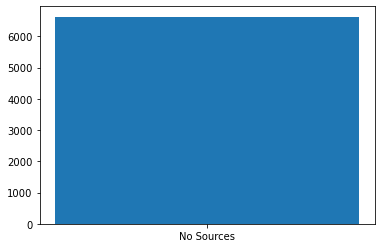

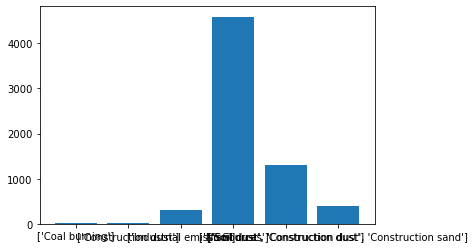

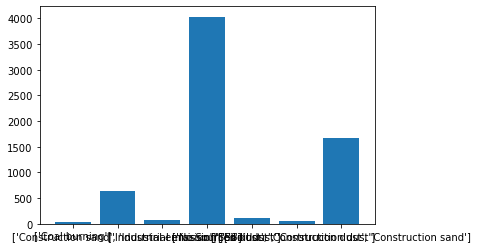

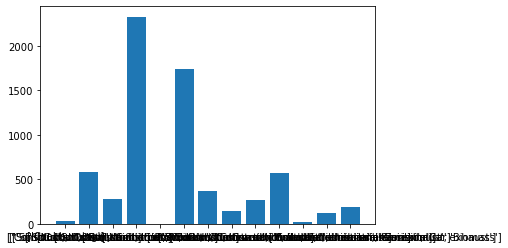

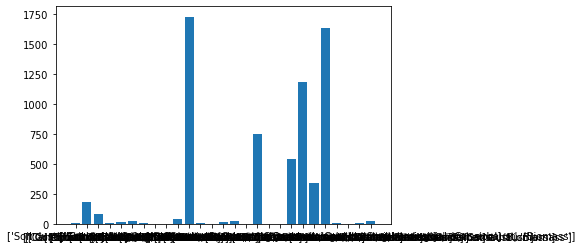

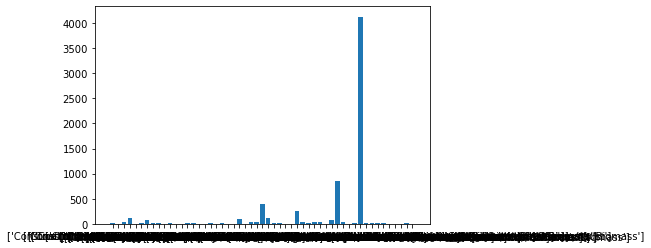

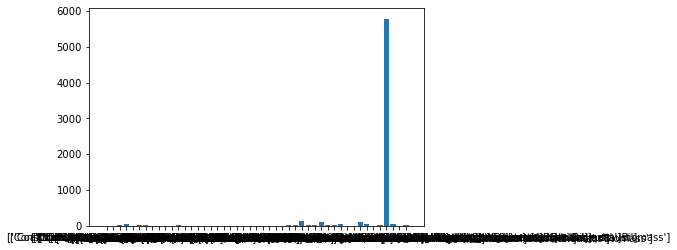

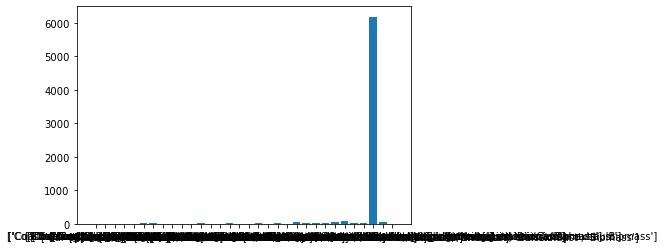

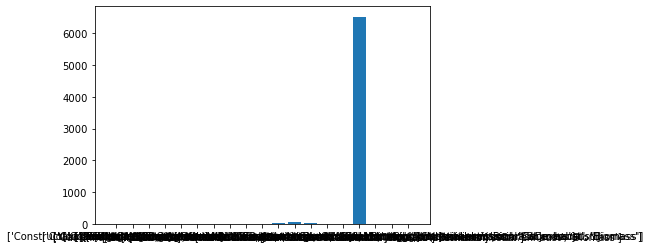

In [24]:
thresholdlist = [0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.97, 0.98, 0.99]

for i in thresholdlist:
    Sourcethreslist = []
    for j in avglist[0]:
        Sourcethreslist.append(threshold(j, Sourcekeys, i))
    
    unique, uniquecounts = np.unique(np.array(Sourcethreslist, dtype = 'object'), return_counts = True)
    
    fig, ax = plt.subplots()
    ax.bar(np.arange(0, len(uniquecounts)), uniquecounts)
    ax.set_xticks(np.arange(0, len(uniquecounts)))
    ax.set_xticklabels([i for i in unique])
    plt.show()
    

In [26]:
from textwrap import wrap

In [30]:
labels = [ '\n'.join(wrap(l,20)) for l in unique]

AttributeError: 'list' object has no attribute 'expandtabs'

In [29]:
labels

['Car exhaust', 'Biomass']